STL decomposition

season - The length of the seasonal smoother. Must be odd.

trend - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.

low_pass - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

In [1]:
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from data.co2_data import get_co2_data
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL, MSTL, DecomposeResult
from statsmodels.datasets import elec_equip as ds
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast


register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

Seasonal-Trend decomposition using LOESS (STL)

In [2]:
stl = STL(get_co2_data(),
    seasonal=13,
    robust=False,
    seasonal_deg=1)
results = stl.fit()

/Users/pepijnschouten/Desktop/Python_Scripts/Python_scripts_Varia/Statsmodels_examples/timeseries/data/co2_data.py:356: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range("1-1-1959", periods=len(co2), freq="M"),


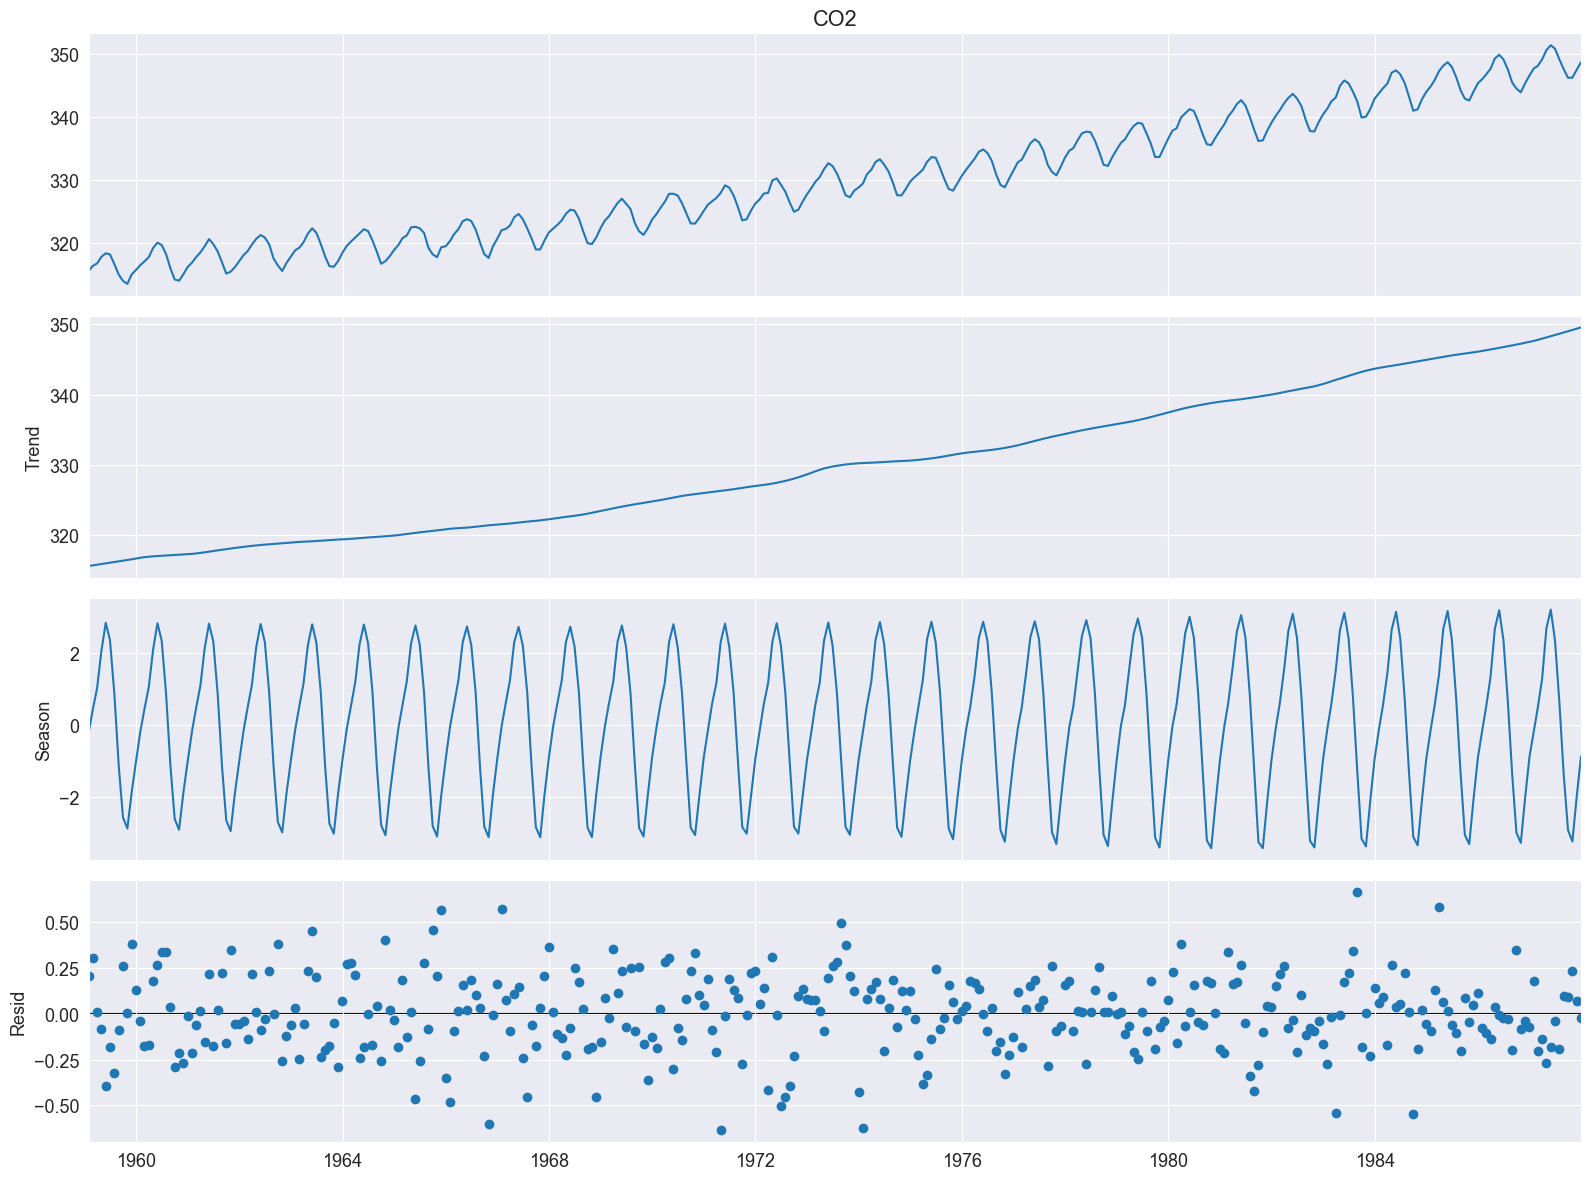

In [3]:
results.plot()
plt.show()

Robust fitting

In [4]:
elec_equip = ds.load().data.iloc[:, 0]

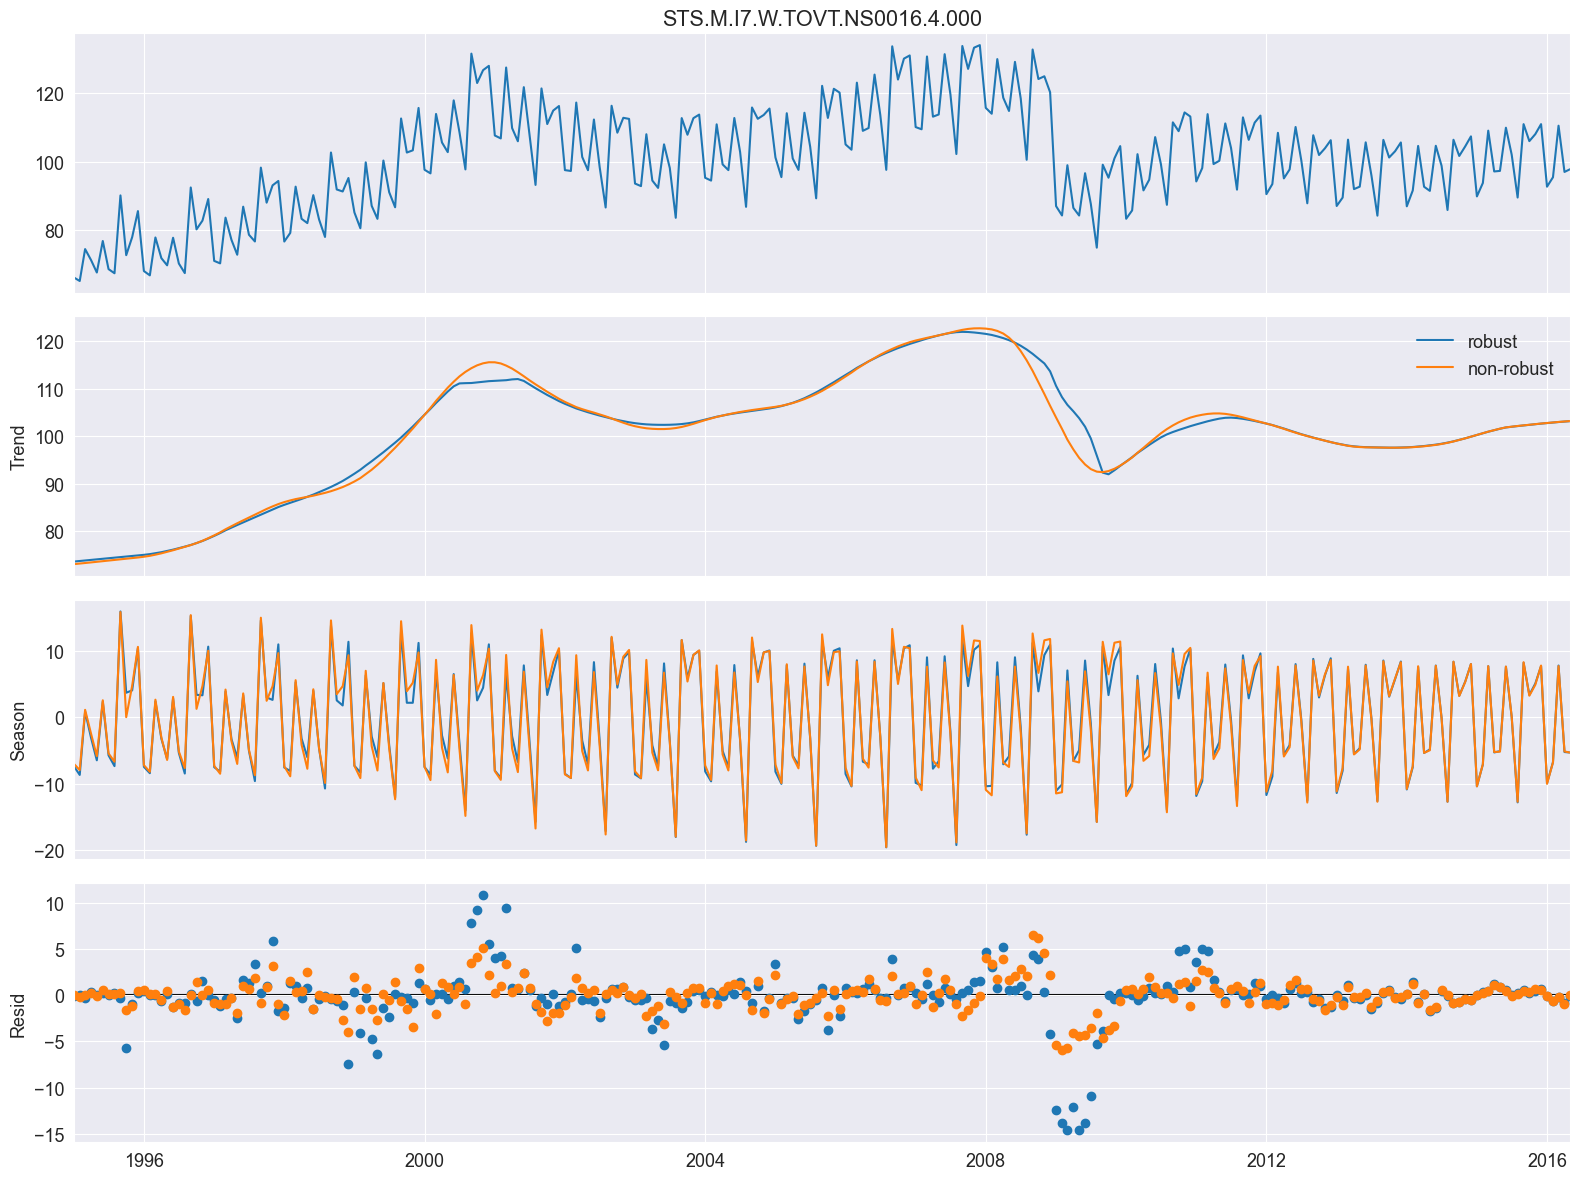

In [5]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

res_robust = STL(elec_equip, period=12, robust=True).fit()
fig = res_robust.plot()
res_non_robust = STL(elec_equip, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["robust","non-robust"])
plt.show()


Forecasting with STL (remove seasonalities and use standard timeseries models)

In [6]:
elec_equip.index.freq = elec_equip.index.inferred_freq
stlf = STLForecast(
    elec_equip,
    ARIMA,
    model_kwargs=dict(order= (1, 0, 0),
                  trend="t")
)
stlf_res = stlf.fit()

forecast = stlf_res.forecast(
    steps=24
)

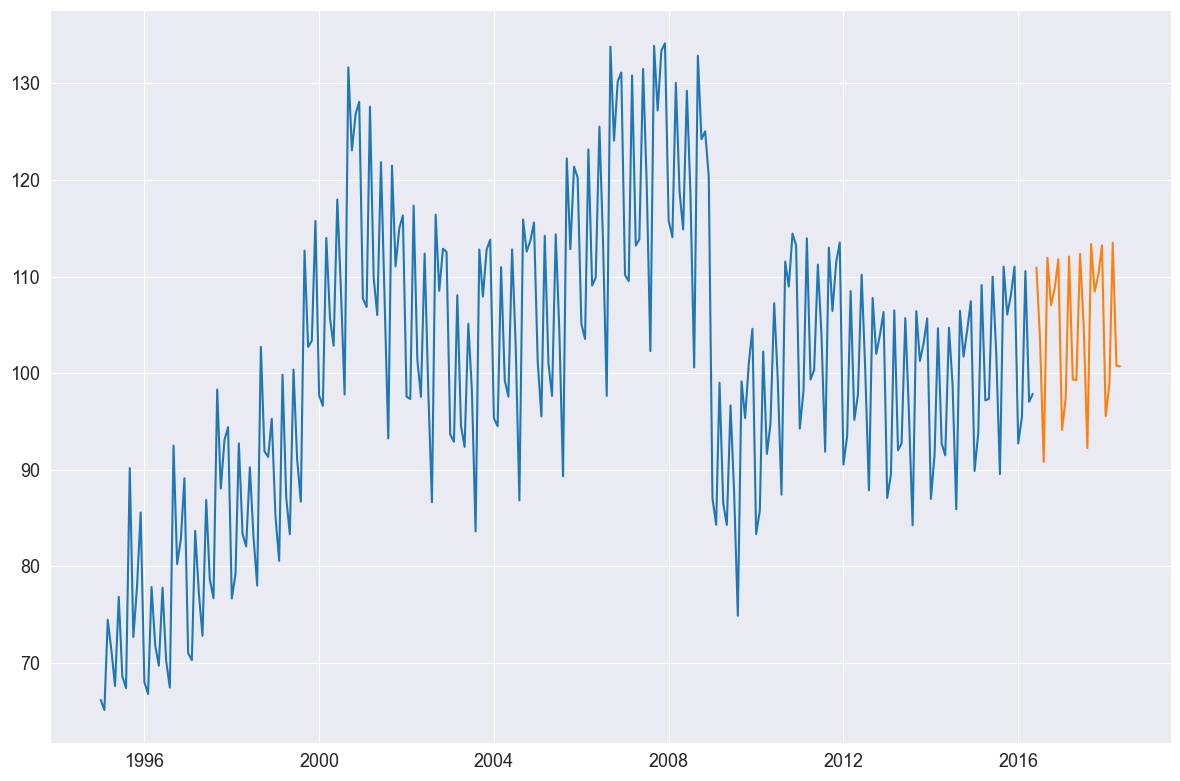

In [7]:
plt.figure(figsize=(12, 8),
           dpi=100,
           tight_layout=True
)
plt.plot(elec_equip)
plt.plot(forecast)
plt.show()

In [8]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  257
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -528.353
Date:                Thu, 19 Dec 2024   AIC                           1062.705
Time:                        01:12:55   BIC                           1073.353
Sample:                    01-01-1995   HQIC                          1066.987
                         - 05-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1415      0.696      0.203      0.839      -1.223       1.506
ar.L1          0.9997      0.008    121.918      0.000       0.984       1.016
sigma2         3.4746      0.175     19.865      0.0

Multiple Seasonal-trend decomposition using LOESS (MSTL)

                            y
2020-01-01 00:00:00  2.940937
2020-01-01 01:00:00  4.901040
2020-01-01 02:00:00  4.207647
2020-01-01 03:00:00  4.414832
2020-01-01 04:00:00  7.244700


/var/folders/pv/ttwy3_md59d5w2n1jcpcn2m80000gp/T/ipykernel_3917/466317252.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = pd.date_range(start='2020-01-01',


<Axes: >

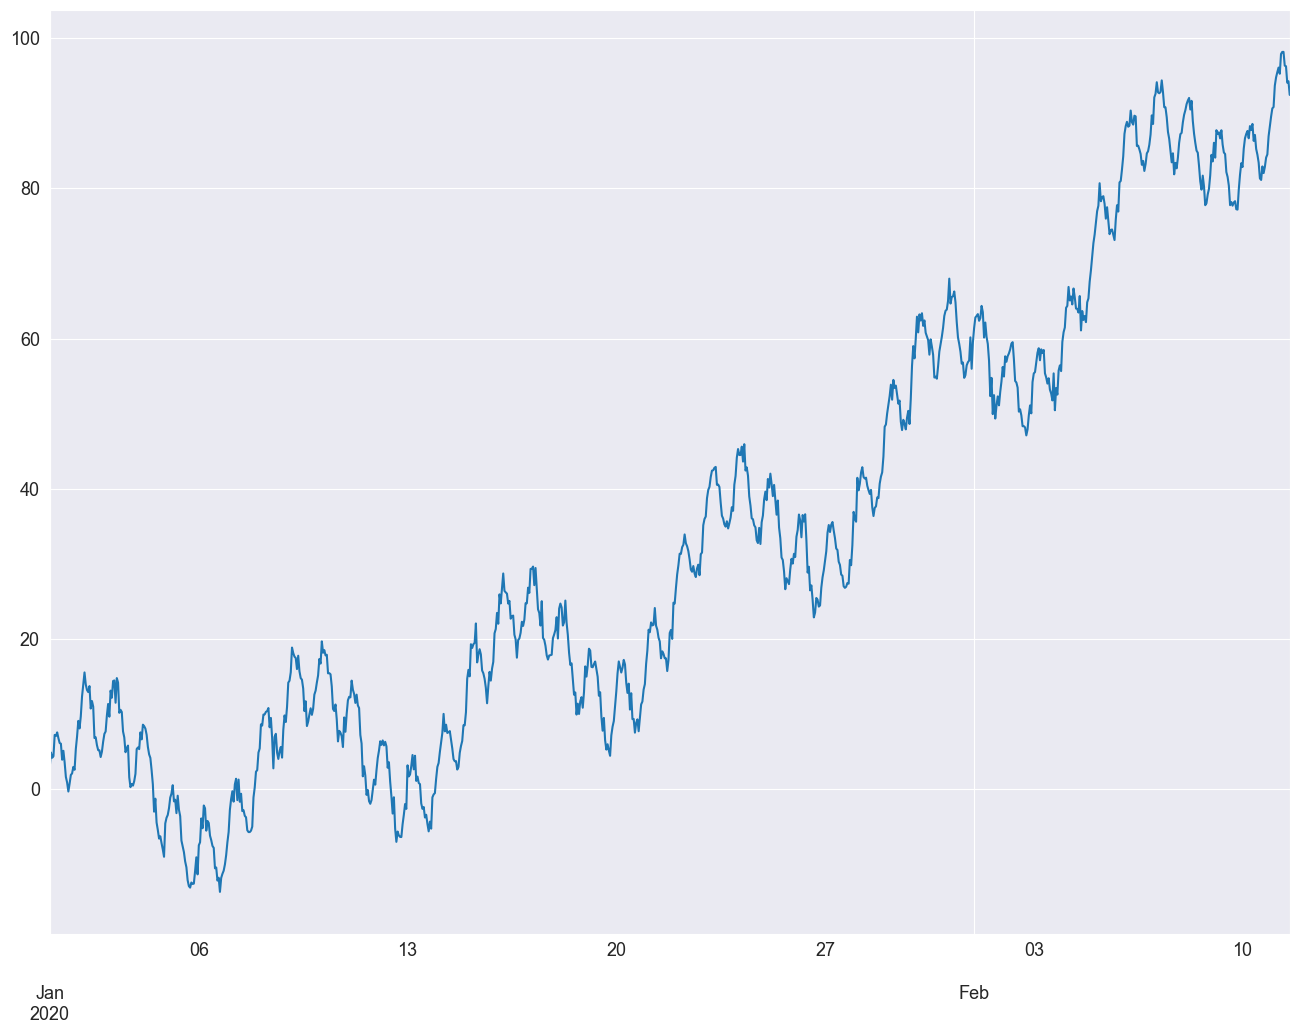

In [9]:
# create toy data
t = np.arange(1, 1000)
daily_season = 5 * np.sin(2 * np.pi * t / 24)
weekly_season = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_season + weekly_season + np.random.randn(len(t))

ts = pd.date_range(start='2020-01-01',
                   freq='H',
                   periods=len(t))
df = pd.DataFrame(data=y,
                  index=ts,
                  columns=['y'])

print(df.head())
df['y'].plot()

                     seasonal_24  seasonal_168
2020-01-01 00:00:00     0.933268      2.296323
2020-01-01 01:00:00     3.451421      2.129702
2020-01-01 02:00:00     3.234536      2.137043
2020-01-01 03:00:00     4.131952      1.709897
2020-01-01 04:00:00     5.698957      2.730747


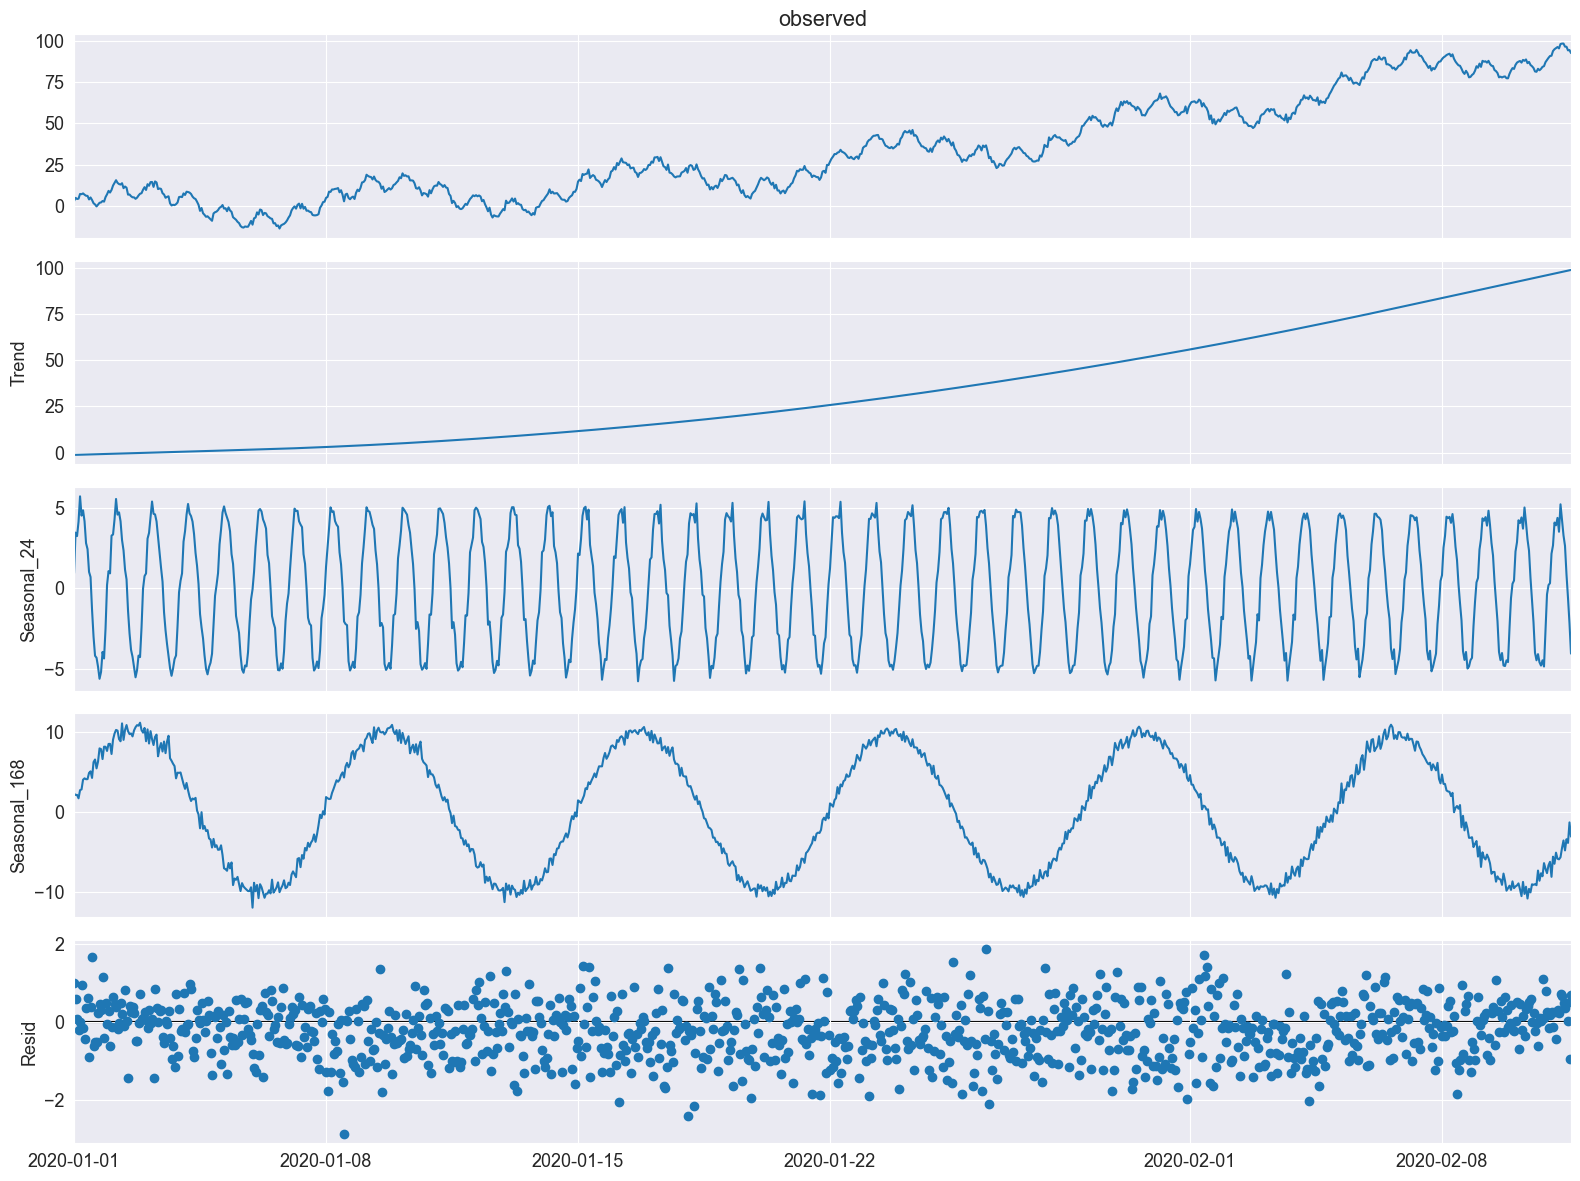

In [10]:
# decompose the data using MSTL
mstl = MSTL(df['y'],
            periods=[24, 24 * 7])
results = mstl.fit()

print(results.seasonal.head())
ax = results.plot()

In [11]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df['Date'] = df['Date'].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="D")
)
df['ds'] = (df['Date'] +
            pd.to_timedelta((df['Period'] - 1) * 30, unit='m'))


print(df.head())

        Date  Period  OperationalLessIndustrial   Industrial  \
0 2002-01-01       1                3535.867064  1086.132936   
1 2002-01-01       2                3383.499028  1088.500972   
2 2002-01-01       3                3655.527552  1084.472448   
3 2002-01-01       4                3510.446636  1085.553364   
4 2002-01-01       5                3294.697156  1081.302844   

                   ds  
0 2002-01-01 00:00:00  
1 2002-01-01 00:30:00  
2 2002-01-01 01:00:00  
3 2002-01-01 01:30:00  
4 2002-01-01 02:00:00  


In [12]:
timeseries = df[['ds', 'OperationalLessIndustrial']].rename(
    columns={'OperationalLessIndustrial': 'y'}
)

# filter for first 149 days
start_date = pd.to_datetime('2012-01-01')
end_date = start_date + pd.Timedelta('149D')

mask = ((timeseries['ds'] >= start_date) &
        (timeseries['ds'] < end_date))
timeseries = timeseries[mask]

# resample to hourly
timeseries = (timeseries
              .set_index('ds')
              .resample('h').sum()
)

print(timeseries.head())

                               y
ds                              
2012-01-01 00:00:00  7926.529376
2012-01-01 01:00:00  7901.826990
2012-01-01 02:00:00  7255.721350
2012-01-01 03:00:00  6792.503352
2012-01-01 04:00:00  6635.984460


                     seasonal_24  seasonal_168
ds                                            
2012-01-01 00:00:00 -1685.986297   -161.807086
2012-01-01 01:00:00 -1591.640845   -229.788887
2012-01-01 02:00:00 -2192.989492   -260.121300
2012-01-01 03:00:00 -2442.169359   -388.484499
2012-01-01 04:00:00 -2357.492551   -660.245476


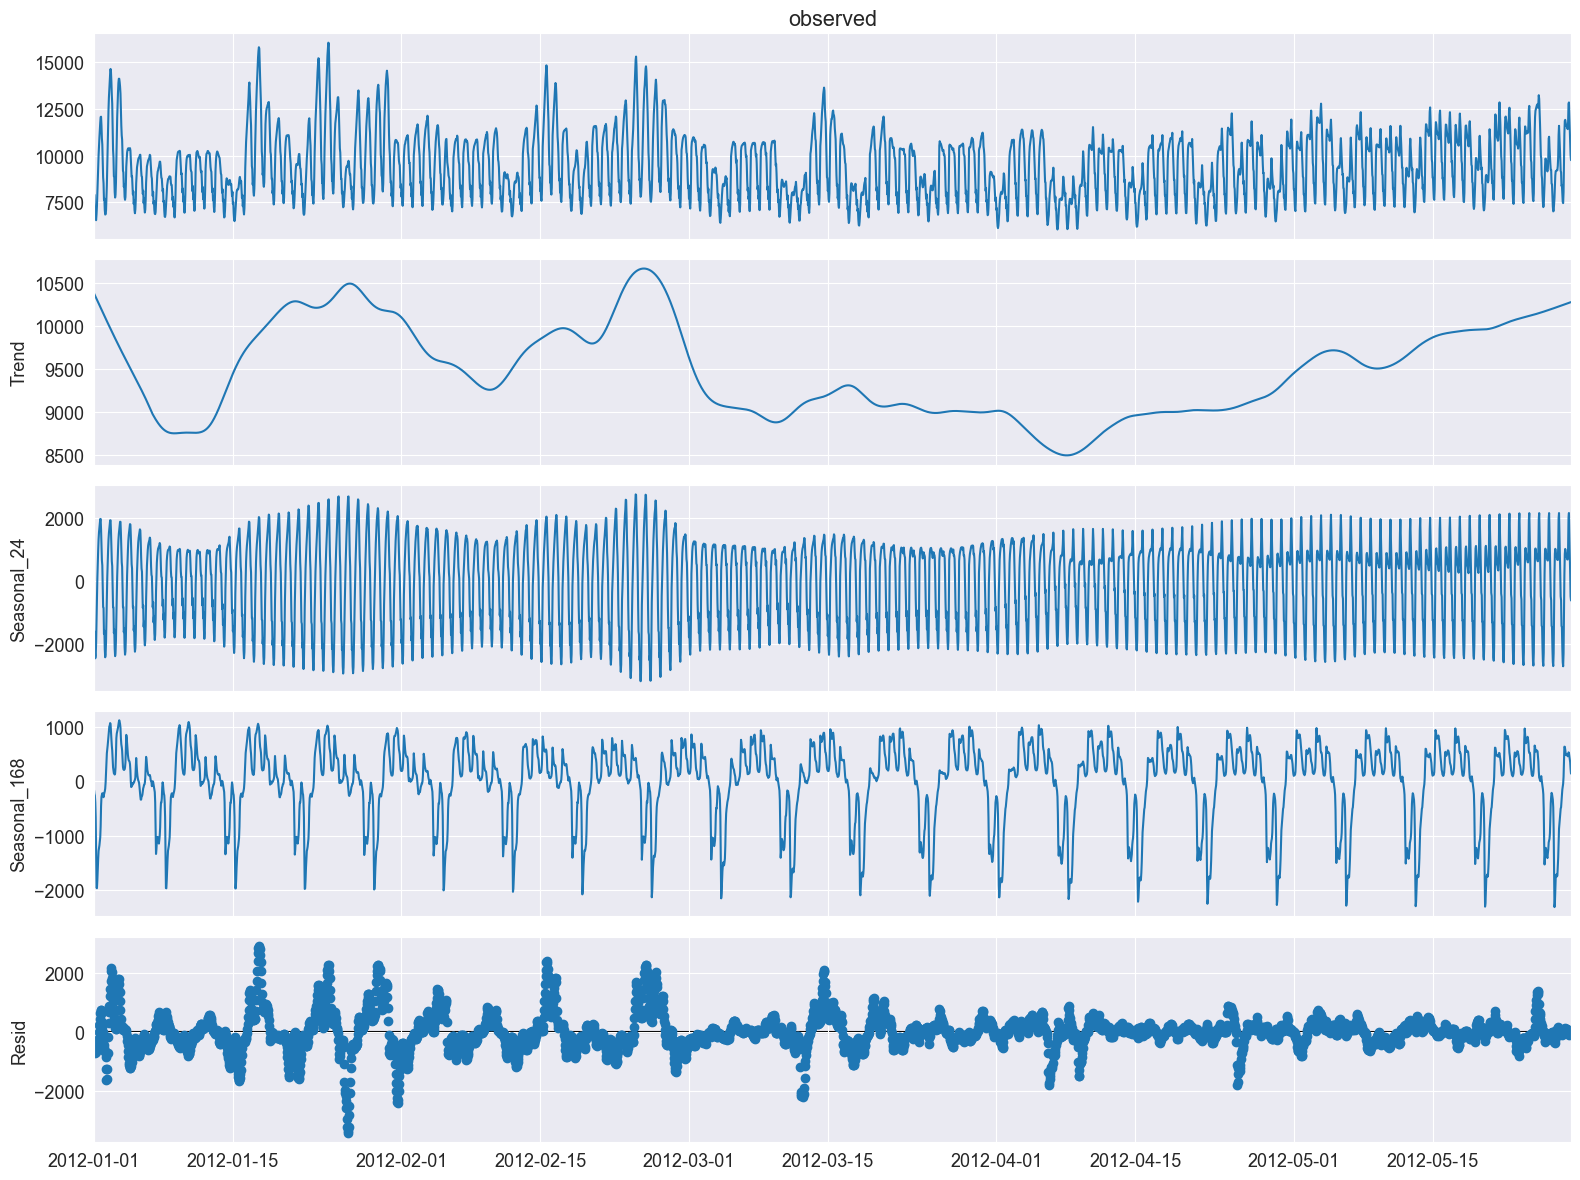

In [13]:
# decompose the data using MSTL
mstl = MSTL(timeseries['y'],
            periods=[24, 24 * 7],
            iterate=3,
            stl_kwargs=dict(seasonal_deg=0,
                            inner_iter=2,
                            outer_iter=0))
results = mstl.fit()

print(results.seasonal.head())
ax = results.plot()
plt.tight_layout()
plt.show()